# Training SVC

## Distribution of Data

Need to make sure that the training data is normalized and has almost equal number of Car and Non-Car samples

Total Cars: 9319
Total Non-Cars: 8968
Total Data: 18287
Total Training: 14629
Total Test: 3657


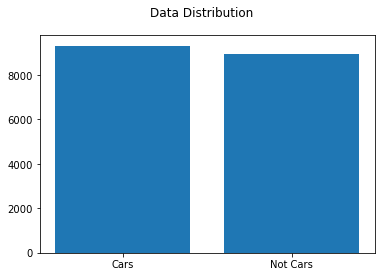

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

cars = glob.glob('./vehicles/**/*.png', recursive=True)
cars.extend(glob.glob('./vehicles/**/*.jpeg', recursive=True))
cars.extend(glob.glob('./additional_data/cars_from_video/*.jpeg'))
            
notcars = glob.glob('./non-vehicles/**/*.png', recursive=True)
notcars.extend(glob.glob('./non-vehicles/**/*.jpeg', recursive=True))
notcars.extend(glob.glob('./additional_data/notcars_from_video/*.jpeg'))
               
count = len(cars) + len(notcars)

print('Total Cars:', len(cars))
print('Total Non-Cars:', len(notcars))
print('Total Data:', count)
print('Total Training:', int(count * 0.8))
print('Total Test:', int(count * 0.2))

data = [len(cars), len(notcars)]
index = np.arange(2)
plt.bar(index, data)
plt.xticks(index, ('Cars', 'Not Cars'))
plt.suptitle('Data Distribution')
plt.show()

## Features Chosen

In [49]:
params = {
    'orient' : 11,
    'pix_per_cell' : 16,
    'cell_per_block' : 2,
    'spatial_feat' : True,
    'hist_feat' : True,
    'hog_feat' : True,
    'color_space' : 'LUV',
    'hog_channel' : 'ALL',
    'spatial_size' : (32,32),
    'hist_bins' : 32,
    'kernel': 'linear',
    'C':1
}

print('Vars Defined:', params)

Vars Defined: {'C': 1, 'pix_per_cell': 16, 'cell_per_block': 2, 'hog_feat': True, 'color_space': 'LUV', 'kernel': 'linear', 'hist_feat': True, 'orient': 11, 'spatial_size': (32, 32), 'hog_channel': 'ALL', 'spatial_feat': True, 'hist_bins': 32}


### Size of each feature

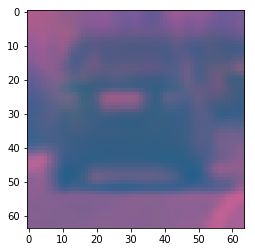

Spatial Features: 3072
Color Histogram features: 96
Hog Features: 1188
Total: 4356
Total confirmed: (4356,)


C:\Users\fahad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [3]:
from lesson_functions import *
import matplotlib.pyplot as plt

img_cs = load_image(cars[0], params['color_space'])
plt.imshow(img_cs)
plt.show()

spatial_features = bin_spatial(img_cs, params['spatial_size']) if params['spatial_feat'] else []
hist_features = color_hist(img_cs, nbins = params['hist_bins']) if params['hist_feat'] else []

if params['hog_channel'] == 'ALL':
    channels = range(img_cs.shape[2])
else:
    channels = [0]

hog_features = []
for channel in channels:
    hog_features.extend(get_hog_features(img_cs[:,:,channel], 
                        orient = params['orient'], 
                        pix_per_cell = params['pix_per_cell'], 
                        cell_per_block = params['cell_per_block'], 
                        vis=False, 
                        feature_vec=True))      

hog_features = np.ravel(hog_features)
total_feature_size = len(spatial_features) + len(hist_features) + len(hog_features)

print('Spatial Features:', len(spatial_features))
print('Color Histogram features:', len(hist_features))
print('Hog Features:', len(hog_features))
print('Total:', total_feature_size)

features = single_img_features(img_cs,
                                spatial_size=params['spatial_size'],
                                hist_bins=params['hist_bins'], 
                                orient=params['orient'], 
                                pix_per_cell=params['pix_per_cell'], 
                                cell_per_block=params['cell_per_block'], 
                                hog_channel=params['hog_channel'],
                                spatial_feat=params['spatial_feat'], 
                                hist_feat=params['hist_feat'],
                                hog_feat=params['hog_feat'])

if features.shape[0] != total_feature_size:
    raise Exception("Check algo, total feature size does not match")
print('Total confirmed:', features.shape)

## SVM Learning

In [58]:
import pickle
import os
from lesson_functions import *
from sklearn.svm import SVC

def svm_train(params, X_train, y_train, X_test, y_test):
    if params['kernel'] == 'linear':
        svc = LinearSVC()
    else:
        svc = SVC(params['kernel'], C=params['C'], gamma=params['gamma'])

    print('Fiting X_train, y_train')
    t = time.time()

    svc.fit(X_train, y_train)

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')

    test_score = svc.score(X_test, y_test)
    train_score = svc.score(X_train, y_train)
    
    print('-' * 100)
    print('Train Accuracy of SVC = ', round(train_score, 4))
    print('Test Accuracy of SVC = ', round(test_score, 4))
    t = time.time()

    n_predict = 150
    svc.predict(X_test[0:n_predict])
    
    t2 = time.time()
    print('Time taken for {} prediction: {}'.format(n_predict, t2-t))
    print('-' * 100)
    
    return svc, test_score, train_score

def train_for_params(params, save_to_file = None):
    print('*' * 100)
    print('Using params:', params)
    print('Extracting car features')
    t1 = time.time()
    car_features = extract_features(cars, 
                                    color_space = params['color_space'], 
                                    orient = params['orient'], 
                                    pix_per_cell = params['pix_per_cell'],
                                    cell_per_block = params['cell_per_block'], 
                                    hog_channel = params['hog_channel'],
                                    spatial_feat = params['spatial_feat'],
                                    spatial_size = params['spatial_size'],
                                    hist_feat = params['hist_feat'],
                                    hog_feat = params['hog_feat'])
    t2 = time.time()
    print('Time taken: {:.2f} secs'.format(t2-t1))
    
    print('Extracting notcar features')
    notcar_features = extract_features(notcars,
                                    color_space = params['color_space'], 
                                    orient = params['orient'], 
                                    pix_per_cell = params['pix_per_cell'],
                                    cell_per_block = params['cell_per_block'], 
                                    hog_channel = params['hog_channel'],
                                    spatial_feat = params['spatial_feat'],
                                    spatial_size = params['spatial_size'],
                                    hist_feat = params['hist_feat'],
                                    hog_feat = params['hog_feat'])

    t1 = time.time()
    print('Time taken: {:.2f} secs'.format(t1-t2))
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    print('X_train size:', X_train.shape)
    print('y_train size:', y_train.shape)
    print('X_test size:', X_test.shape)
    print('y_test size:', y_test.shape)
    print('Feature vector length:', len(X_train[0]))
    
    svc, test_score, train_score = svm_train(params, X_train, y_train, X_test, y_test)
    
    if save_to_file is not None:
        with open(save_to_file, 'wb') as f:
            data = {'svm':svc, 
                    'scaler': X_scaler,
                    'params' : params
                   }
            pickle.dump(data, f)
            print('Saved params to', save_to_file)
    
    return svc, test_score, train_score, len(X_train[0])

    
#train_for_params(params, './svm.p')

****************************************************************************************************
Using params: {'C': 1, 'pix_per_cell': 16, 'cell_per_block': 2, 'hog_feat': True, 'color_space': 'LUV', 'kernel': 'linear', 'hist_feat': True, 'orient': 11, 'spatial_size': (32, 32), 'hog_channel': 'ALL', 'spatial_feat': True, 'hist_bins': 32}
Extracting car features


C:\Users\fahad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Time taken: 26.93 secs
Extracting notcar features
Time taken: 25.85 secs
X_train size: (14629, 4356)
y_train size: (14629,)
X_test size: (3658, 4356)
y_test size: (3658,)
Feature vector length: 4356
Fiting X_train, y_train
10.43 Seconds to train SVC...
----------------------------------------------------------------------------------------------------
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9855
Time taken for 150 prediction: 0.0009999275207519531
----------------------------------------------------------------------------------------------------
Saved params to ./svm.p


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), 0.98551120831055217, 1.0, 4356)

In [59]:
training = []

all_params = [
    {
        'orient' : 11, 'pix_per_cell' : 16, 'cell_per_block' : 2,
        'color_space' : 'LUV',
        'hog_channel' : 'ALL',
        'spatial_feat' : True,'hist_feat' : True,'hog_feat' : True,
        'spatial_size' : (32,32),'hist_bins' : 32,
        'kernel' : 'linear','C': 1,'gamma': 'auto'
    },
    {
        'orient' : 11, 'pix_per_cell' : 16, 'cell_per_block' : 2,
        'color_space' : 'YCrCb',
        'hog_channel' : 'ALL',
        'spatial_feat' : True,'hist_feat' : True,'hog_feat' : True,
        'spatial_size' : (32,32),'hist_bins' : 32,
        'kernel' : 'linear','C': 1,'gamma': 'auto'
    },
    {
        'orient' : 11, 'pix_per_cell' : 16, 'cell_per_block' : 2,
        'color_space' : 'LUV',
        'hog_channel' : 'ALL',
        'spatial_feat' : True,'hist_feat' : True,'hog_feat' : True,
        'spatial_size' : (32,32),'hist_bins' : 32,
        'kernel' : 'linear','C': 100,'gamma': 'auto'
    },
    {
        'orient' : 11, 'pix_per_cell' : 16, 'cell_per_block' : 2,
        'color_space' : 'LUV',
        'hog_channel' : 'ALL',
        'spatial_feat' : True,'hist_feat' : True,'hog_feat' : True,
        'spatial_size' : (32,32),'hist_bins' : 32,
        'kernel' : 'linear','C': 1000,'gamma': 'auto'
    },
    {
        'orient' : 9, 'pix_per_cell' : 8, 'cell_per_block' : 2,
        'color_space' : 'LUV',
        'hog_channel' : 'ALL',
        'spatial_feat' : True,'hist_feat' : True,'hog_feat' : True,
        'spatial_size' : (32,32),'hist_bins' : 32,
        'kernel' : 'linear','C': 1,'gamma': 'auto'
    },
    {
        'orient' : 12, 'pix_per_cell' : 8, 'cell_per_block' : 4,
        'color_space' : 'LUV',
        'hog_channel' : 'ALL',
        'spatial_feat' : True,'hist_feat' : True,'hog_feat' : True,
        'spatial_size' : (32,32),'hist_bins' : 32,
        'kernel' : 'linear','C': 1,'gamma': 'auto'
    },
    {
        'orient' : 9, 'pix_per_cell' : 16, 'cell_per_block' : 2,
        'color_space' : 'LUV',
        'hog_channel' : 'ALL',
        'spatial_feat' : True,'hist_feat' : True,'hog_feat' : True,
        'spatial_size' : (32,32),'hist_bins' : 32,
        'kernel' : 'linear','C': 1,'gamma': 'auto'
    },
]

for check_params in all_params:
    svc, test_score, train_score, feature_length = train_for_params(check_params)
    training.append({
        'params' : params,
        'svc':svc,
        'train_score':train_score,
        'test_score':test_score,
        'feature_length': feature_length})
    
print('~' * 100)
with open('training.p', 'wb') as f:
    pickle.dump(training_params, f)
    print('All performances saved to: training.p')

print('Summary:')
for train_set in training:
    params = train_set['params']
    print('=' * 100)
    print('Pixels per cell:', params['pix_per_cell'])
    print('Cells per block:', params['cell_per_block'])
    print('Orientation:', params['orient'])
    print('Color Spaec:', params['color_space'])
    print('Hog Channel:', params['hog_channel'])
    print('Kernel:', params['kernel'])
    print('C:', params['C'])
    print('Test score:', train_set['test_score'])
    print('Feature Length:', train_set['feature_length'])

****************************************************************************************************
Using params: {'C': 1, 'pix_per_cell': 16, 'cell_per_block': 2, 'hog_feat': True, 'color_space': 'LUV', 'kernel': 'linear', 'gamma': 'auto', 'hist_feat': True, 'orient': 11, 'spatial_size': (32, 32), 'hog_channel': 'ALL', 'spatial_feat': True, 'hist_bins': 32}
Extracting car features


C:\Users\fahad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Time taken: 26.72 secs
Extracting notcar features
Time taken: 26.05 secs
X_train size: (14629, 4356)
y_train size: (14629,)
X_test size: (3658, 4356)
y_test size: (3658,)
Feature vector length: 4356
Fiting X_train, y_train
9.98 Seconds to train SVC...
----------------------------------------------------------------------------------------------------
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9855
Time taken for 150 prediction: 0.0015001296997070312
----------------------------------------------------------------------------------------------------
****************************************************************************************************
Using params: {'C': 1, 'pix_per_cell': 16, 'cell_per_block': 2, 'hog_feat': True, 'color_space': 'YCrCb', 'kernel': 'linear', 'gamma': 'auto', 'hist_feat': True, 'orient': 11, 'spatial_size': (32, 32), 'hog_channel': 'ALL', 'spatial_feat': True, 'hist_bins': 32}
Extracting car features
Time taken: 25.66 secs
Extracting notcar feat

## SVM Training

In [40]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()

print('Fiting X_train, y_train')
svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('-' * 100)
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print('-' * 100)

# Check the prediction time for a single sample
t=time.time()
n_predict = 10

print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

with open('./svm.p', 'wb') as f:
    data = {'svm':svc, 
            'scaler': X_scaler,
            'params' : params
           }
    pickle.dump(data, f)
    
print('Classifier saved to svm.p')

Fiting X_train, y_train
10.58 Seconds to train SVC...
----------------------------------------------------------------------------------------------------
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9885
----------------------------------------------------------------------------------------------------
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  0.  1.  0.  0.]
0.0015 Seconds to predict 10 labels with SVC
Classifier saved to svm.p


In [39]:
svc = None

with open('./svm.p', 'rb') as f:
    svc = data['svm']
    X_scaler = data['scaler']
    params = data['params']

n_samples = 1000
car_indices = np.random.choice(len(cars), n_samples, replace=False)
notcar_indices = np.random.choice(len(notcars), n_samples, replace=False)

car_random_sample = [cars[i] for i in car_indices]
notcar_random_sample = [notcars[i] for i in notcar_indices]

print('Extracting features of random sub sample of cars')
car_features = extract_features(car_random_sample, 
                                color_space = params['color_space'], 
                                orient = params['orient'], 
                                pix_per_cell = params['pix_per_cell'],
                                cell_per_block = params['cell_per_block'], 
                                hog_channel = params['hog_channel'],
                                spatial_feat = params['spatial_feat'],
                                spatial_size = params['spatial_size'],
                                hist_feat = params['hist_feat'],
                                hog_feat = params['hog_feat'])
                               
print('Extracting features for random notcar sub sample')
notcar_features = extract_features(notcar_random_sample,
                                color_space = params['color_space'], 
                                orient = params['orient'], 
                                pix_per_cell = params['pix_per_cell'],
                                cell_per_block = params['cell_per_block'], 
                                hog_channel = params['hog_channel'],
                                spatial_feat = params['spatial_feat'],
                                spatial_size = params['spatial_size'],
                                hist_feat = params['hist_feat'],
                                hog_feat = params['hog_feat'])


# # Create an array stack of feature vectors
X_subsample = np.vstack((car_features, notcar_features)).astype(np.float64)
y_subsample = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_subsample_scaled = X_scaler.transform(X_subsample)

shuffle_indices = np.random.choice(len(X_subsample), len(X_subsample), replace=False)
print(shuffle_indices[:10])

score = svc.score(X_subsample_scaled[shuffle_indices], y_subsample[shuffle_indices])
print('Accuracy of random test:', score)

Extracting features of random sub sample of cars


C:\Users\fahad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Extracting features for random notcar sub sample
[   1  873 1451  983  768 1006 1290 1425 1910 1803]
Accuracy of random test: 0.996


Params {'hist_feat': True, 'orient': 11, 'spatial_size': (32, 32), 'pix_per_cell': 16, 'cell_per_block': 2, 'hog_feat': True, 'hog_channel': 'ALL', 'color_space': 'LUV', 'spatial_feat': True, 'hist_bins': 32}
Is it a car? 1.0


C:\Users\fahad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


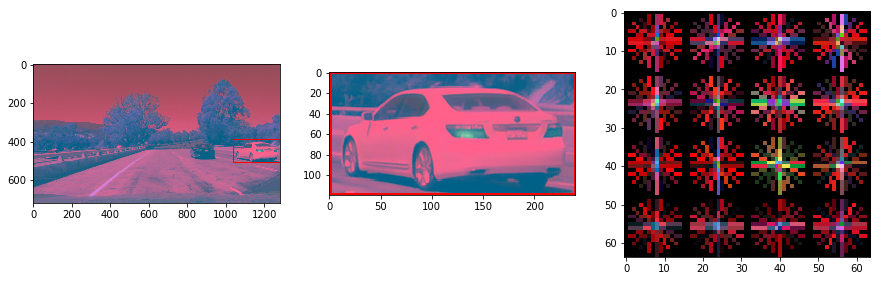

In [38]:
from lesson_functions import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

print('Params', params)
img = load_image('./test_images/test1.jpg', params['color_space'])

box = [(1040,390),(1280,510)]
box_pixels = img[box[0][1]:box[1][1], box[0][0]:box[1][0]]

small_img = cv2.resize(box_pixels, (64,64))
features, hog_images = single_img_features(small_img, 
                                orient = params['orient'], 
                                pix_per_cell = params['pix_per_cell'],
                                cell_per_block = params['cell_per_block'], 
                                hog_channel = params['hog_channel'],
                                spatial_feat = params['spatial_feat'],
                                spatial_size = params['spatial_size'],
                                hist_feat = params['hist_feat'],
                                hog_feat = params['hog_feat'],
                                vis = True)

scaled_img = X_scaler.transform([features])

predict = svc.predict(scaled_img)
print('Is it a car?', predict[0])

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

cv2.rectangle(img, box[0], box[1], (255,0,0), 3)
ax1.imshow(img)
ax2.imshow(box_pixels)
ax3.imshow(hog_images)